# Training Data Acquisition and Labeling

In this notebook, we go through the dataset and create spectrograms of instances of drum sounds in audio, which we then label based on their .midi pitch. The result of this notebook is a spectrogram for each drum instance and a .csv label for each audiofile.

## Setup

In [1]:
%matplotlib inline

import tensorflow as tf
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import mido
import pygame

pygame 2.3.0 (SDL 2.24.2, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


This dictionary specifies the necessary labels that need to be transferred into a .csv file. We are essentially turning the .midi into Python-friendly data while labeling the spectrograms for **each** note instance.

In [2]:
midi_to_name = {
    36: "kick",
    37: "snare click",
    38: "snare",
    40: "snare (electric)",
    42: "high-hat (closed)",
    43: "tom (floor 1)",
    44: "high-hat (foot)",
    45: "tom (low)",
    46: "high-hat (open)",
    48: "tom (high-mid)",
    50: "tom (high)",
    51: "ride",
    53: "ride (bell)",
    55: "splash",
    59: "ride 2"
}

## What are MIDI ticks?

Note that the `time` value for events in MIDI files is measured in **delta time MIDI ticks**. 

A tick is the smallest unit of time in MIDIs, and their duration is defined by the `ticks_per_beat` parameter stored in the MIDI file. In our dataset, all files have a fixed `ticks_per_beat` value of `480`, which means every beat lasts 480 ticks. Now, traditionally, a song's beat duration or tempo is defined by BPM, beats per minute. In case of MIDIs however, the `tempo` is measured in microseconds per beat. For example, 100 BPM would equate to 600,000 μSPB. 

To convert $BPM$ to $\mu{SPB}$, we can use the following formula: 

$$ \mu{SPB} = \frac{60}{BPM} \cdot 10^6 $$

The formula for converting ticks to seconds would like something like this: 

$$ t_{sec} = \frac{t_{tick} \cdot \mu{SPB}}{TPB \cdot 10^6} $$

where:

* $t_{sec}$ is the absolute time in seconds
* $t_{tick}$ is the absolute time in ticks
* $TPB$ is the number of ticks per beat specified in the MIDI file
* $\mu SPB$ is the tempo of the MIDI file in microseconds per beat

For convenience, the `mido` package has built-in conversion functions like `bpm2tempo(bpm)`, `tempo2bpm(tempo)` and `tick2second(tick, ticks_per_beat, tempo)`.

## Getting MIDI onsets

The following function takes a MIDI track as input and extracts some features from it, including time signatures, tempos, and note events. Essentially, the __delta time__ `time` parameter indicates when each note should be played relative to the previous one. In order to get __absolute__ tick-time for one event, we can sum up the `time` of every event preceding it.

In [18]:
def get_midi_features(track):
    timesignatures = []
    tempos = []
    notes = []
    time = 0
    events = [event.dict() for event in track]
    
    for x in events:
        time += x["time"] # the time variable with previous event times is summed with the current event's time...
        if x["type"] == "note_on":
            if x["velocity"] == 0:
                x["type"]="note_off"
            elif x["velocity"] > 100:
                x["velocity"] = 100
            target = notes
        elif x["type"] == "note_off":
            target = notes
        elif x["type"] == "time_signature":
            target = timesignatures
        elif x["type"] == "set_tempo":
            target = tempos
        else: 
            continue
        x["time"] = time # ...becoming absolute time
        target.append(x)
    return {"time_signatures": timesignatures, "tempos": tempos, "notes": notes}

mid = mido.MidiFile('groove/drummer9/session1/1_rock_100_beat_4-4.mid', clip=True)
features = get_midi_features(mid.tracks[0])

In [4]:
csv_df = pd.read_csv("groove/info.csv")
train_df = csv_df[(csv_df.split=="train")]
train_df

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
10,drummer1,drummer1/session1,drummer1/session1/1,funk,80,beat,4-4,drummer1/session1/1_funk_80_beat_4-4.mid,drummer1/session1/1_funk_80_beat_4-4.wav,86.704688,train
11,drummer1,drummer1/session1,drummer1/session1/10,jazz/funk,116,fill,4-4,drummer1/session1/10_jazz-funk_116_fill_4-4.mid,drummer1/session1/10_jazz-funk_116_fill_4-4.wav,1.872843,train
12,drummer1,drummer1/session1,drummer1/session1/100,neworleans/secondline,94,beat,4-4,drummer1/session1/100_neworleans-secondline_94...,drummer1/session1/100_neworleans-secondline_94...,135.365719,train
13,drummer1,drummer1/session1,drummer1/session1/101,dance/disco,120,beat,4-4,drummer1/session1/101_dance-disco_120_beat_4-4...,drummer1/session1/101_dance-disco_120_beat_4-4...,207.572917,train
14,drummer1,drummer1/session1,drummer1/session1/102,funk,95,beat,4-4,drummer1/session1/102_funk_95_beat_4-4.mid,drummer1/session1/102_funk_95_beat_4-4.wav,224.807558,train
...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train


In [5]:
for track in train_df[:1].iterrows():
    #print(track[1]["midi_filename"])
    mid = mido.MidiFile('groove/'+track[1]["midi_filename"], clip=True)
    #mid = mido.MidiFile('groove/drummer9/session1/1_rock_100_beat_4-4.mid', clip=True)
    features = get_midi_features(mid.tracks[0])
    df = pd.DataFrame(features["notes"])
    dfcount = df.replace({'note': midi_to_name}).groupby(['type','note'])['velocity'].count()['note_on']
    #print(mid.ticks_per_beat)
print(dfcount)

note
???                    8
high-hat (closed)    400
high-hat (foot)       24
high-hat (open)       22
kick                 120
snare                179
snare (electric)       1
snare click           18
tom (floor 1)          1
Name: velocity, dtype: int64


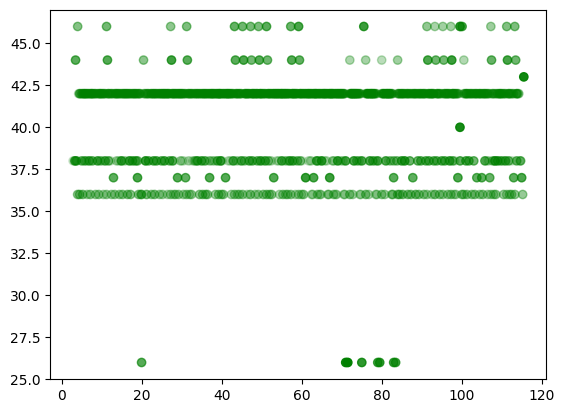

In [16]:
#plt.scatter(df[df.type=="note_off"]["time"]/mid.ticks_per_beat, df[df.type=="note_off"]["note"], c="r")
plt.scatter(df[df.type=="note_on"]["time"]/mid.ticks_per_beat, df[df.type=="note_on"]["note"], c="g", alpha=df[df.type=="note_on"]["velocity"]/100)
plt.show()

## Working with .wav files

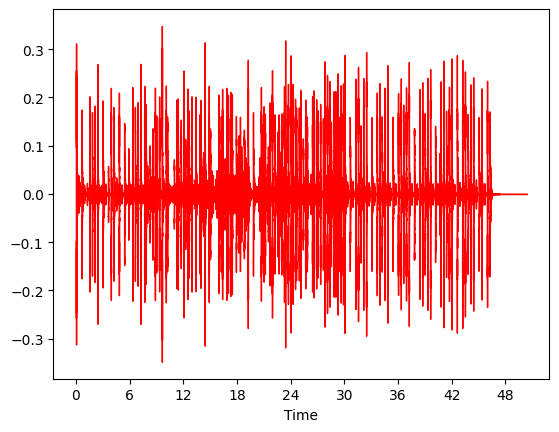

In [12]:
y, sr = librosa.load('groove/drummer9/session1/1_rock_100_beat_4-4.wav')
librosa.display.waveshow(y,sr=sr, axis='time', color='red')
plt.show()

In [ ]:
tf.audio.decode_wav('groove/drummer9/session1/1_rock_100_beat_4-4.wav')

window_size = 1024
hop_size = 512

def sliding_window(audio, window_size, hop_size):
    audio_len = tf.shape(audio)[0]
    num_frames = tf.cast(tf.math.ceil((audio_len - window_size) / hop_size), tf.int32) + 1
    frames = tf.TensorArray(tf.float32, size=num_frames, dynamic_size=False, infer_shape=True)
    for i in tf.range(num_frames):
        start = i * hop_size
        end = start + window_size
        frames = frames.write(i, audio[start:end])
    return frames.stack()